In [25]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque
import heapq


# General settings
seed = 42
# image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 5
unsafe_iterations = 5


start_coordinate = [4,0]
goal_coordinate = [4,1]
start_heading = 'S'


In [26]:

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id,x,y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes.keys() and node_id2 in self.nodes.keys():
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight
        
    '''
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight
            # add edge going the opposite direction as well
            if node_id2 not in self.edges:
                self.edges[node_id2] = {}
            self.edges[node_id2][node_id1] = weight
    '''

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id2 in self.edges[node_id1]:
                del self.edges[node_id1][node_id2]
            if node_id1 in self.edges[node_id2]:
                del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_nodes_val(self):
        return list(self.nodes.values())
    
    def get_neighbours(self, node_id):
        if node_id in self.edges:
            return list(self.edges[node_id].keys()) 
        else:
            return []






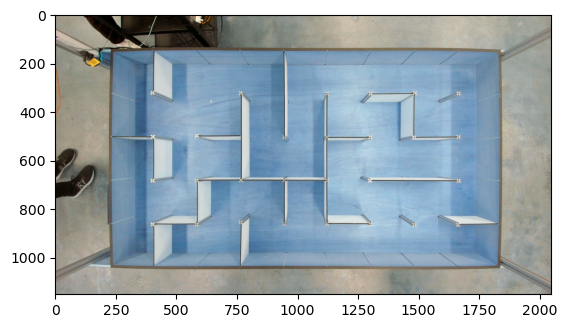

[[ 9.45783133e-01  3.88578059e-16 -2.17530120e+02]
 [-3.88578059e-16  9.71910112e-01 -1.45786517e+02]
 [-3.25260652e-19  2.43945489e-19  1.00000000e+00]]


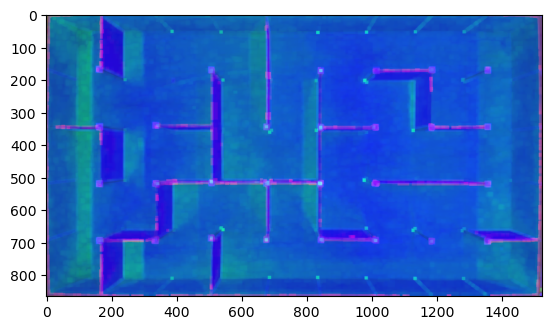

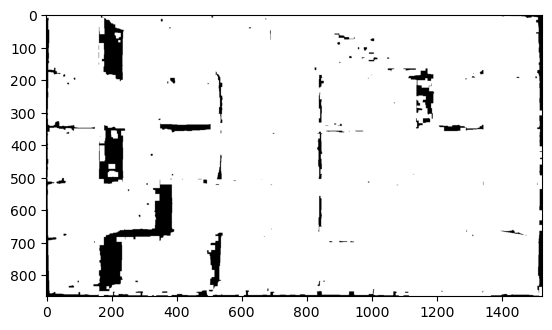

In [27]:

img = cv2.imread('maze_test_on_day.jpg') # TODO: Replace with code to load the image
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plt.imshow(img)
plt.show()
# pts1 = np.float32([[215,125],[1740,125],[215,990],[1740,990]]) # four points on the first image
# pts1 = np.float32([[230,150],[1890,150],[230,1040],[1890,1040]]) # four points on the first image - RAM
# pts1 = np.float32([[84,167],[1993,174],[84,1235],[1992,1240]]) # four points on the first image - MICHAEL

# pts1 = np.float32([[500,250],[3500,250],[500,2000],[3500,2000]]) # four points on the first image - MICHAEL



# pts2 = np.float32([[0,0],[1525,0],[0,865],[1525,865]]) # four points on the second image
# pts2 = np.float32([[0,0],[3700,0],[0,2100],[3700,2100]]) # four points on the second image - RAM
# pts2 = np.float32([[0,0],[1909,0],[0,1068],[1909,1068]]) # four points on the second image - MICHAEL

target_size = (2048, 1152)

# Resize the image
imgHSV = cv2.resize(imgHSV, target_size, interpolation=cv2.INTER_LINEAR)



pts1 = np.float32([[230,150],[1890,150],[230,1040],[1890,1040]]) # four points on the first image
# pts2 = np.float32([[0,0],[1525,0],[0,865],[1525,865]]) # four points on the second image
pts2 = np.float32([[0,0],[1570,0],[0,865],[1570,865]]) # four points on the second image


H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)
cropped_image = cv2.warpPerspective(imgHSV, H, (1525,865))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

cropped_image = cv2.dilate(cropped_image,kernel,iterations=4)

plt.imshow(cropped_image)
plt.show()




# imgHSVMasked = cv2.inRange(cropped_image,(6,45,98),(87,255,237))
imgHSVMasked = cv2.inRange(cropped_image,(20,0,0),(168,115,219))

imgHSVFinal = imgHSVMasked.copy()
imgHSVFinal = cv2.cvtColor(imgHSVFinal, cv2.COLOR_GRAY2RGB)  # Convert single channel to BGR
imgHSVFinal = cv2.erode(imgHSVFinal, kernel, iterations=3)
inverted_image = cv2.bitwise_not(imgHSVFinal)
# inverted_image = cv2.dilate(inverted_image, kernel, iterations=2)
plt.imshow(inverted_image)
plt.show()



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


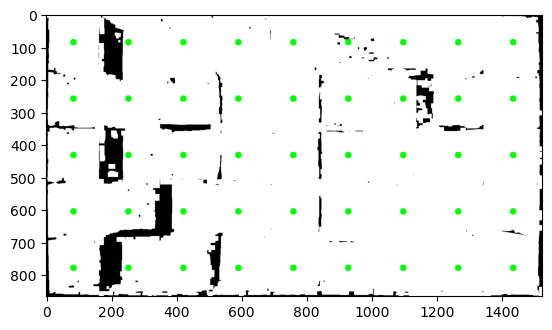

In [28]:
bfs_image = inverted_image.copy()
bfs_graph = Graph()

height,width,_ = bfs_image.shape
x_step = width//(9)
y_step = height//(5)

# bfs_image = cv2.circle(bfs_image,(300,200),10,(0,255,0),-1)
# bfs_image = cv2.circle(bfs_image,(550,200),10,(0,255,0),-1)

def in_obstacle_bound(col, row, x_start, x_end, y_start, y_end):
    #print(x_start, col, x_end, "  ",y_start, row, y_end )
    #print(x_start >= col >= x_end)
   # print(y_start >= row >= y_end)
    return x_start <= col <= (x_start+x_end - 1) and y_start <= row <= y_end


node_id = 0
for row in range(5):
    for col in range(9):
        x = int(((col+0.5)*x_step))
        y = int(((row+0.5)*y_step))
                     
        bfs_graph.add_node((node_id),x,y)
        node_id += 1
            #print((x_step//3))
            

            
        # bfs_image = cv2.circle(bfs_image,(int(x),int(y)),10,(0,255,0),-1)
        #node_id += 1
        
'''

'''
        
node_list = bfs_graph.get_nodes()

#drawing circles
radius = 10
color = (0, 255, 0)  # Green color in BGR
thickness = -1  # Thickness of the circle outline

for i in range(len(node_list)): 
    node = node_list[i]
    cv2.circle(bfs_image, (bfs_graph.nodes[node].x, bfs_graph.nodes[node].y), radius, color, thickness)  



nodes_list_first = bfs_graph.get_nodes()
print(nodes_list_first)
plt.imshow(bfs_image,cmap='gray')
plt.show()

In [29]:
def path_clear(image, x1, y1, x2, y2):
    clear = True
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    x = abs(x2-x1)
    y = abs(y2-y1)

    # if the nodes are vertical (same x axis, different y values)
    # should be equal to 0, but in case there are rounding discrepancies in coordinate values
    if x == 0:
        for i in range(y):
            # if there is an red or black obstacle, return false
            if( image[y2+i,x1] == [0,0,0]).all():
                clear = False
    
    # if the nodes are horizontal (same y axis, different x values)
    else:
        for i in range(x):

            if (image[y1][x2+i] == [0,0,0]).all():
                clear = False    
    return clear

def is_close(x1, x2, tol=1.0):
    return abs(x1 - x2) <= tol

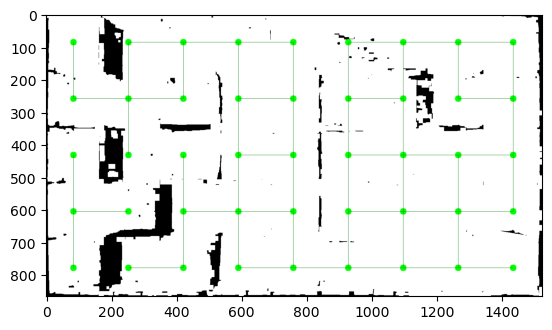

In [30]:
node_list = bfs_graph.get_nodes_val()


def path_clear_r(image, x1, y1, x2, y2):
    
    # Bresenham's line algorithm
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        # Check if the current pixel is not white
        if np.array_equal(image[y1, x1], [0, 0, 0]):
            return False
        
        if x1 == x2 and y1 == y2:
            break

        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return True


for i in node_list:
    row_nodes = [node for node in node_list if abs(node.y - i.y) < 1]
    row_nodes = sorted(row_nodes, key=lambda node: node.x)
    nodee = [node.id for node in row_nodes]
    #print(nodee)
    ith_index = row_nodes.index(i)
    if (ith_index - 1) >= 0:
        if path_clear_r(bfs_image, i.x, i.y, row_nodes[ith_index - 1].x, row_nodes[ith_index - 1].y):
            bfs_graph.add_edge(i.id, row_nodes[ith_index - 1].id, 1)
    if (ith_index + 1) < len(row_nodes)-1:
        if path_clear_r(bfs_image, i.x, i.y, row_nodes[ith_index + 1].x, row_nodes[ith_index + 1].y):
            bfs_graph.add_edge(i.id, row_nodes[ith_index + 1].id, 1)
        
    col_nodes = [node for node in node_list if abs(node.x - i.x) < 1]
    col_nodes = sorted(col_nodes, key=lambda node: node.y)
    ith_index = col_nodes.index(i)
    if (ith_index - 1) >= 0:
        if path_clear_r(bfs_image, i.x, i.y, col_nodes[ith_index - 1].x, col_nodes[ith_index - 1].y):
            bfs_graph.add_edge(i.id, col_nodes[ith_index - 1].id, 1)
    if (ith_index + 1) < len(col_nodes)-1:
        if path_clear_r(bfs_image, i.x, i.y, col_nodes[ith_index + 1].x, col_nodes[ith_index + 1].y):
            bfs_graph.add_edge(i.id, col_nodes[ith_index + 1].id, 1)
        
    

for key in bfs_graph.edges.keys():
    #print(key)
    for end in bfs_graph.edges[key].keys():
        #print(end)
        node = bfs_graph.nodes[key]
        end_node = bfs_graph.nodes[end]
        cv2.line(bfs_image, (node.x, node.y), (end_node.x, end_node.y), (0, 125, 0), 1)    
        
                        
plt.imshow(bfs_image)
plt.show()

In [31]:
def distance(node, target_x, target_y):
    return math.sqrt((node.x - target_x) ** 2 + (node.y - target_y) ** 2)

def find_closest_node(image, graph, target_x, target_y):
    nodes = graph.get_nodes_val()
    distances = sorted(nodes, key=lambda node: distance(node, target_x, target_y))

    return distances[0]

def bfs(graph, start_node_id, end_node_id):
    
    queue = deque([start_node_id])
    visited = set()
    parents = {start_node_id: None}
    
    while queue:
        current_node_id = queue.popleft()
        
        # Skip this node if we have already visited it
        if current_node_id in visited:
            continue
        
        # Mark this node as visited
        visited.add(current_node_id)
        
        # Check if we have reached the end node
        if current_node_id == end_node_id:
            path = []
            while current_node_id is not None:
                path.append(current_node_id)
                current_node_id = parents[current_node_id]
            path.reverse()
            return path
        
        # Get neighbours of the current node
        neighbours = graph.get_neighbours(current_node_id)
        
        # Reverse the order of the neighbours to match the spec
        neighbours.reverse()
        
        # Add neighbours to the queue and set their parent
        for neighbour_id in neighbours:
            if neighbour_id not in visited and neighbour_id not in queue:
                queue.append(neighbour_id)
                parents[neighbour_id] = current_node_id
    
    # If no path is found, return an empty list
    return []

# Task 3.2: Impliment BFS continued



x = int(((col+0.5)*x_step))
y = int(((row+0.5)*y_step))

start_coordinate_row = (start_coordinate[0]+0.5)*x_step
start_coordinate_column = (start_coordinate[1]+0.5)*y_step

goal_coordinate_row = (goal_coordinate[0]+0.5)*x_step
goal_coordinate_column = (goal_coordinate[1]+0.5)*x_step
print(goal_coordinate_row)

# Run bfs and display the output
# start_node = find_closest_node(bfs_image, bfs_graph, 100, 100)
start_node = find_closest_node(bfs_image, bfs_graph, start_coordinate_column, start_coordinate_row)

print(start_node.id)

# end_node = find_closest_node(bfs_image, bfs_graph, 1500, 800)
end_node = find_closest_node(bfs_image, bfs_graph, goal_coordinate_column, goal_coordinate_row)

#print(end_node.id)

path = bfs(bfs_graph, start_node.id, end_node.id)

length = len(path)
for i in range(length-1):
    x1,y1 = bfs_graph.nodes[path[i]].get_point()
    x2,y2 = bfs_graph.nodes[path[i+1]].get_point()
    
    cv2.line(bfs_image, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),2)



# Display resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()



In [ ]:



def find_direction(graph, path):
     # north is index 0, east 1, south 2, west 3
     # right 0, left 1, up 2, down 3

    lookup_normal = [
    ["rf", "lf", "f", " error "], #north
    ["f", " error ", "lf", "rf"], #east
    ["lf", "rf", " error ", "f"], #south
    [" error ", "f", "rf", "lf"]  #west
    ]

    lookup_short = [
    ["rs", "ls", "s", " error "], #north
    ["s", " error ", "ls", "rs"], #east
    ["ls", "rs", " error ", "s"], #south
    [" error ", "s", "rs", "ls"]  #west
    ]


    if start_heading == 'N':
        start_heading_number = 0
    elif start_heading == 'E':
        start_heading_number = 1
    elif start_heading == 'S':
        start_heading_number = 2
    elif start_heading == 'W':
        start_heading_number = 3


    commands = ""
    heading = 0


    start_direction_array = ['N', 'E', 'S', 'W']
     

    
    if graph.nodes[path[1]].x > graph.nodes[path[0]].x:
        heading = 1 #east
    elif graph.nodes[path[1]].x < graph.nodes[path[0]].x:
         heading = 3 #west
    elif graph.nodes[path[1]].y < graph.nodes[path[0]].y:
        heading = 0 #north
    elif graph.nodes[path[1]].y > graph.nodes[path[0]].y:
        heading = 2 #south

    # difference = start_heading_number - heading
    # print(difference)

    angle_difference = heading - start_heading_number
    
    # Normalize the difference to be within [-180, 180]
    difference = (angle_difference) % 4

    if difference == 1:
        commands = commands + "rf" 
    elif difference == 2:
        commands = commands + "rrf" 
    elif difference == 3:
        commands = commands + "lf" 
    else:
        commands = commands + "f" 
   
    

    
    for i in range(1, len(path) - 1):
        #print(heading)
        if graph.nodes[path[i+1]].x > graph.nodes[path[i]].x: #east
            if distance(graph.nodes[path[i]], graph.nodes[path[i+1]].x, graph.nodes[path[i+1]].y) > 100:
                 commands += lookup_normal[heading][0]
            else:
                 commands += lookup_short[heading][0]
            heading = 1
             #print("east")
        elif graph.nodes[path[i+1]].x < graph.nodes[path[i]].x: #west
            if distance(graph.nodes[path[i]], graph.nodes[path[i+1]].x, graph.nodes[path[i+1]].y) > 100:
                commands += lookup_normal[heading][1]
            else:
                commands += lookup_short[heading][1]
            heading = 3
             #print("west")
        elif graph.nodes[path[i+1]].y < graph.nodes[path[i]].y: #north
            if distance(graph.nodes[path[i]], graph.nodes[path[i+1]].x, graph.nodes[path[i+1]].y) > 100:
                commands += lookup_normal[heading][2]
            else:
                commands += lookup_short[heading][2]
            heading = 0
             #print("north")
        elif graph.nodes[path[i+1]].y > graph.nodes[path[i]].y: #south
            if distance(graph.nodes[path[i]], graph.nodes[path[i+1]].x, graph.nodes[path[i+1]].y) > 100:
                commands += lookup_normal[heading][3]
            else:
                commands += lookup_short[heading][3]
            heading = 2
             #print("south")
    return commands
    print(commands)
print(find_direction(bfs_graph,path))

rrfrflffrflfrfrfflffrflfrfrfffrflflfrf
